In [688]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import peakutils
from scipy import signal
import matplotlib.pyplot as plt
import random
import json

In [689]:
EXPERIMENT_NAME = 'P3856'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'

In [690]:
METRICS_INDEX = 19

In [691]:
metrics_files_l = glob.glob('{}/debug/run-{}-sequence-*-metrics.json'.format(EXPERIMENT_DIR, RUN_NAME))
METRICS_FILE_NAME = metrics_files_l[METRICS_INDEX]

In [692]:
with open(METRICS_FILE_NAME, 'r') as f:
    metrics = json.load(f)

In [693]:
metrics.keys()

dict_keys(['sequence', 'charge', 'run_name', 'estimated_coordinates_d', 'rt_flattened_l', 'scan_flattened_l', 'feature_metrics_attributes_l', 'selected_peak_index'])

In [694]:
feature_attributes_d = metrics['feature_metrics_attributes_l'][0][4]

#### visualising the raw points in the isotopic peak series

In [695]:
isotope_intensities_l = feature_attributes_d['isotope_intensities_l']

In [696]:
len(isotope_intensities_l)

7

In [697]:
isotopes_df_l = [pd.DataFrame(d[4], columns=['mz','scan','frame_id','retention_time_secs','intensity']) for d in isotope_intensities_l]

In [698]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [699]:
tableau20_py = tableau20.copy()

In [700]:
import chart_studio.plotly as py
import plotly.graph_objs as go

traces = []

for isotope_idx in range(0,len(isotopes_df_l)):
    df = isotopes_df_l[isotope_idx]
    df["hover"] = df["mz"].map('{:,.2f} m/z'.format) + ', ' + df["scan"].map('{:,.0f} scan'.format) + ', ' + df["retention_time_secs"].map('RT {:.1f} secs'.format)
    if len(df) > 0:
        trace = go.Scatter3d(
            x = df.mz,
            y = df.retention_time_secs,
            z = df.intensity,
            mode = 'markers',
            marker = dict(
                size = 5,
                color = "rgb{}".format(tableau20_py[isotope_idx+2]),
                opacity = 0.7
            ),
            text = df.hover,
            hoverinfo = 'text',
            name = "isotope {}".format(isotope_idx)
        )
        traces.append((trace))

data = traces
layout = go.Layout(
    autosize=True,
    height=1000,
    title="Isotopes for the feature identified as {}, charge {}".format(metrics['sequence'], metrics['charge']),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=40
    ),
    scene = dict(
        xaxis = dict(
            title='m/z', autorange='reversed'),
        yaxis = dict(
            title='RT'),
        zaxis = dict(
            title='intensity'),
        aspectmode = "manual",
        aspectratio = dict( x = 10, y = 5, z = 5)
    )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [701]:
fig.write_html('/Users/darylwilding-mcbride/Downloads/interactive-test.html')

#### finding apexes in retention time and mobility

In [702]:
mono_rt_lower = feature_attributes_d['mono_rt_bounds'][0]
mono_rt_upper = feature_attributes_d['mono_rt_bounds'][1]
rt_0_df = pd.DataFrame(metrics['rt_flattened_l'][0])
rt_0_peak_df = rt_0_df[(rt_0_df.retention_time_secs >= mono_rt_lower) & (rt_0_df.retention_time_secs <= mono_rt_upper)]

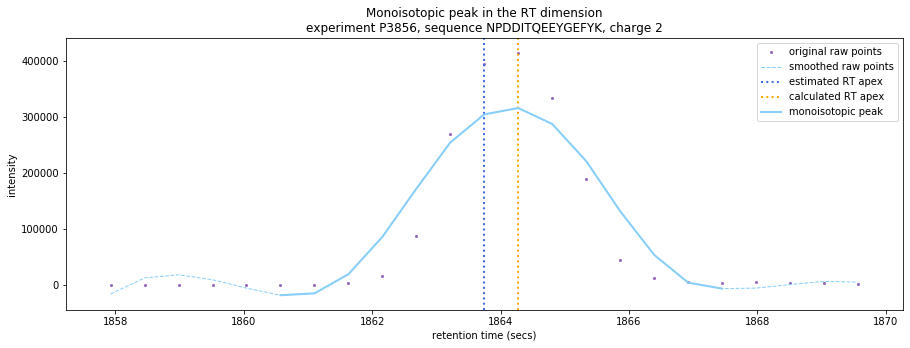

In [703]:
f, ax = plt.subplots()
f.set_figheight(5)
f.set_figwidth(15)

# plot the original raw data
ax.plot(rt_0_df.retention_time_secs, rt_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')

# if rt_0_metrics['number_of_peaks'] > 0:
#     # plot the original filtered data constrained to a single peak
#     ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
#     # plot the fitted curve
#     ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')

# show the estimated apex
plt.axvline(x=metrics['estimated_coordinates_d']['rt_apex'], linestyle=':', color='royalblue', linewidth=2, label='estimated RT apex')

# show the calculated apex
plt.axvline(x=feature_attributes_d['rt_apex'], linestyle=':', color='orange', linewidth=2, label='calculated RT apex')

# show the extent of the peak
ax.plot(rt_0_peak_df.retention_time_secs, rt_0_peak_df.filtered_intensity, marker='', color='lightskyblue', linestyle='-', linewidth=2, ms=5, label='monoisotopic peak')

plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
plt.title('Monoisotopic peak in the RT dimension\nexperiment {}, sequence {}, charge {}'.format(EXPERIMENT_NAME, metrics['sequence'], metrics['charge']))
plt.margins(0.06)
plt.show()

In [704]:
mono_scan_lower = feature_attributes_d['mono_scan_bounds'][0]
mono_scan_upper = feature_attributes_d['mono_scan_bounds'][1]
scan_0_df = pd.DataFrame(metrics['scan_flattened_l'][0])

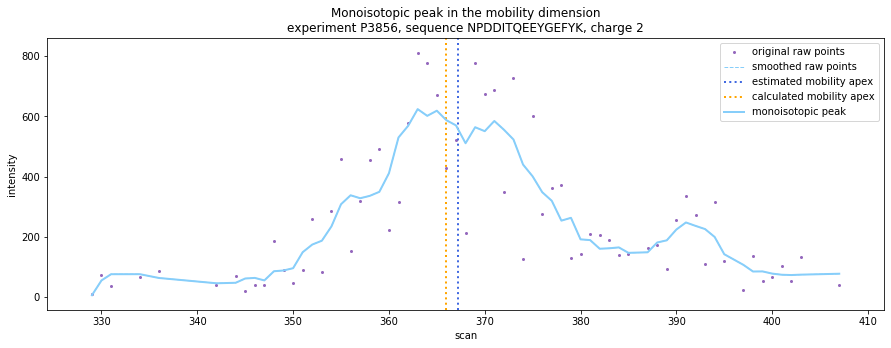

In [705]:
f, ax = plt.subplots()
f.set_figheight(5)
f.set_figwidth(15)

# plot the original raw data
ax.plot(scan_0_df.scan, scan_0_df.intensity, marker='o', color='tab:purple', linestyle='', linewidth=2, ms=2, label='original raw points')
# plot the filtered intensity values
ax.plot(scan_0_df.scan, scan_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=1, ms=5, label='smoothed raw points')

# if rt_0_metrics['number_of_peaks'] > 0:
#     # plot the original filtered data constrained to a single peak
#     ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].filtered_intensity, marker='', color='steelblue', linestyle='--', linewidth=1, ms=5, label='single peak raw points')
#     # plot the fitted curve
#     ax.plot(rt_0_metrics['fitted_curve_df'].retention_time_secs, rt_0_metrics['fitted_curve_df'].fitted_intensity, marker='', color='orangered', linestyle='-', linewidth=1, ms=5, label='single peak fitted points')

# show the estimated apex
plt.axvline(x=metrics['estimated_coordinates_d']['scan_apex'], linestyle=':', color='royalblue', linewidth=2, label='estimated mobility apex')

# show the calculated apex
plt.axvline(x=feature_attributes_d['scan_apex'], linestyle=':', color='orange', linewidth=2, label='calculated mobility apex')

# show the extent of the peak
peak_df = scan_0_df[(scan_0_df.scan >= mono_scan_lower) & (scan_0_df.scan <= mono_scan_upper)]
ax.plot(peak_df.scan, peak_df.filtered_intensity, marker='', color='lightskyblue', linestyle='-', linewidth=2, ms=5, label='monoisotopic peak')

plt.xlabel('scan')
plt.ylabel('intensity')
plt.legend(loc='best')
plt.title('Monoisotopic peak in the mobility dimension\nexperiment {}, sequence {}, charge {}'.format(EXPERIMENT_NAME, metrics['sequence'], metrics['charge']))
plt.margins(0.06)
plt.show()

Visualise the isotopic peak correlation with each other in RT

In [706]:
isotope1_rt_lower = feature_attributes_d['isotope_1_rt_bounds'][0]
isotope1_rt_upper = feature_attributes_d['isotope_1_rt_bounds'][1]
rt_1_df = pd.DataFrame(metrics['rt_flattened_l'][1])
rt_1_peak_df = rt_1_df[(rt_1_df.retention_time_secs >= isotope1_rt_lower) & (rt_1_df.retention_time_secs <= isotope1_rt_upper)]

In [707]:
isotope2_rt_lower = feature_attributes_d['isotope_2_rt_bounds'][0]
isotope2_rt_upper = feature_attributes_d['isotope_2_rt_bounds'][1]
rt_2_df = pd.DataFrame(metrics['rt_flattened_l'][2])
rt_2_peak_df = rt_2_df[(rt_2_df.retention_time_secs >= isotope2_rt_lower) & (rt_2_df.retention_time_secs <= isotope2_rt_upper)]

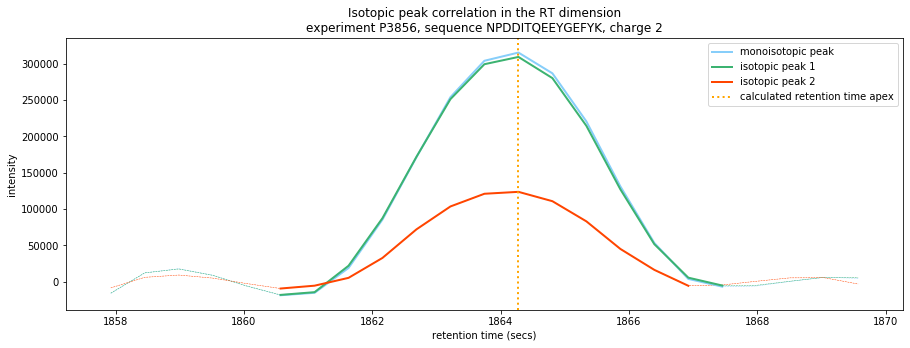

In [708]:
f, ax = plt.subplots()
ax.plot(rt_0_df.retention_time_secs, rt_0_df.filtered_intensity, marker='', color='lightskyblue', linestyle='--', linewidth=0.5, ms=2)
ax.plot(rt_1_df.retention_time_secs, rt_1_df.filtered_intensity, marker='', color='mediumseagreen', linestyle='--', linewidth=0.5, ms=2)
ax.plot(rt_2_df.retention_time_secs, rt_2_df.filtered_intensity, marker='', color='orangered', linestyle='--', linewidth=0.5, ms=2)

# isolated peak
ax.plot(rt_0_peak_df.retention_time_secs, rt_0_peak_df.filtered_intensity, marker='', color='lightskyblue', linestyle='-', linewidth=2, ms=2, label='monoisotopic peak')
ax.plot(rt_1_peak_df.retention_time_secs, rt_1_peak_df.filtered_intensity, marker='', color='mediumseagreen', linestyle='-', linewidth=2, ms=2, label='isotopic peak 1')
ax.plot(rt_2_peak_df.retention_time_secs, rt_2_peak_df.filtered_intensity, marker='', color='orangered', linestyle='-', linewidth=2, ms=2, label='isotopic peak 2')

# show the calculated apex
plt.axvline(x=feature_attributes_d['rt_apex'], linestyle=':', color='orange', linewidth=2, label='calculated retention time apex')

plt.xlabel('retention time (secs)')
plt.ylabel('intensity')
plt.legend(loc='best')
f.set_figheight(5)
f.set_figwidth(15)
plt.title('Isotopic peak correlation in the RT dimension\nexperiment {}, sequence {}, charge {}'.format(EXPERIMENT_NAME, metrics['sequence'], metrics['charge']))
plt.margins(0.06)
plt.show()